**Function 5:**

Yield in a Chemical Reaction. This time you are trying to optimise another four-dimensional black-box. It corresponds to the yield of a chemical process after processing in some factory. This type of process tends to be unimodal. Try to find the combination of chemicals that maximizes the yield!

In [8]:
from sklearn.gaussian_process import GaussianProcessRegressor
from scipy.stats import norm
from scipy.optimize import minimize
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [9]:
f5_inputs = np.load("initial_inputs.npy")
f5_outputs = np.load("initial_outputs.npy")
f5_inputs_2 = np.load("initial_inputs2.npy")
f5_outputs_2 = np.load("initial_outputs2.npy")

In [10]:
f5_inputs = np.concatenate((f5_inputs, f5_inputs_2)) 
f5_inputs = np.concatenate((f5_inputs, np.array([[0.329622, 0.319559, 0.335951, 0.275429]]))) 
f5_inputs = np.concatenate((f5_inputs, np.array([[0.630732, 0.255243, 0.163612, 0.663668]]))) 
f5_inputs = np.concatenate((f5_inputs, np.array([[0.136884, 0.175429, 0.750162, 0.240518]]))) 
f5_inputs = np.concatenate((f5_inputs, np.array([[0.156884, 0.185429, 0.730162, 0.834869]]))) 
f5_inputs = np.concatenate((f5_inputs, np.array([[0.221966, 0.848702, 0.877261, 0.876293]]))) 
f5_inputs = np.concatenate((f5_inputs, np.array([[0.2353  , 0.835369, 0.890595, 0.889626]]))) 
f5_inputs = np.concatenate((f5_inputs, np.array([[0.255301, 0.815369, 0.910595, 0.909626]]))) 
f5_inputs = np.concatenate((f5_inputs, np.array([[0.275301, 0.795369, 0.930595, 0.929626]]))) 
f5_inputs = np.concatenate((f5_inputs, np.array([[0.295301, 0.775369, 0.950595, 0.949626]]))) 
f5_inputs = np.concatenate((f5_inputs, np.array([[0.30362 , 0.92081 , 0.951794, 0.890271]]))) 
f5_inputs = np.concatenate((f5_inputs, np.array([[0.30362 , 0.956366, 0.956239, 0.872493]]))) 
f5_inputs = np.concatenate((f5_inputs, np.array([[0.288064, 0.967477, 0.954016, 0.856937]]))) 
f5_inputs = np.concatenate((f5_inputs, np.array([[0.305842, 0.976366, 0.962905, 0.87027]]))) 
f5_inputs = np.concatenate((f5_inputs, np.array([[0.290286, 0.996366, 0.982905, 0.890271]]))) 
f5_inputs = np.concatenate((f5_inputs, np.array([[0.283619, 0.996366, 0.994016, 0.905826]]))) 
f5_inputs = np.concatenate((f5_inputs, np.array([[0.285841, 0.987477, 0.994016, 0.925826]]))) 
f5_inputs = np.concatenate((f5_inputs, np.array([[0.283618, 0.985544, 0.999999, 0.936937]]))) 
f5_inputs = np.concatenate((f5_inputs, np.array([[0.281395, 0.978877, 0.999999, 0.956937]]))) 

f5_outputs = np.concatenate((f5_outputs,f5_outputs_2))
f5_outputs = np.append(f5_outputs,131.1962333718706)
f5_outputs = np.append(f5_outputs,8.319139067926972)
f5_outputs = np.append(f5_outputs,15.916258413112816)
f5_outputs = np.append(f5_outputs,65.62143113848653)
f5_outputs = np.append(f5_outputs,1077.2793665718714)
f5_outputs = np.append(f5_outputs,1151.2287899694788)
f5_outputs = np.append(f5_outputs,1283.9813760530844)
f5_outputs = np.append(f5_outputs,1446.3325506169003)
f5_outputs = np.append(f5_outputs,1642.712076836066)
f5_outputs = np.append(f5_outputs,2043.5758440370957)
f5_outputs = np.append(f5_outputs,2246.9353067103452)
f5_outputs = np.append(f5_outputs,2221.1489548557843)
f5_outputs = np.append(f5_outputs,2475.0054048920615)
f5_outputs = np.append(f5_outputs,3030.1696296258147)
f5_outputs = np.append(f5_outputs,3286.085078568141)
f5_outputs = np.append(f5_outputs,3367.83461018011)
f5_outputs = np.append(f5_outputs,3526.9798701929503)
f5_outputs = np.append(f5_outputs,3659.8420356222346)


In [4]:
X_max= f5_inputs[np.argmax(abs(f5_outputs))]
print(X_max)

[0.281395 0.978877 0.999999 0.956937]


In [5]:
Y_max= f5_outputs[np.argmax(abs(f5_outputs))]
print(Y_max)

3659.8420356222346


In [6]:
#f5_outputs = []
#f5_outputs = [1088.85961819627]
#f5_outputs = [355.8068177560159]
#f5_outputs =[131.1962333718706]

In [15]:
def costly_function(x):
    total = np.array([])
    for x_i in x:
         total = np.append(total, np.sum(np.exp(-(x_i - 5) ** 2)))
    return total  + np.random.randn()

In [89]:
class BayesianOptimizer():
      
    def __init__(self, target_func, x_init, y_init, n_iter, scale, batch_size):
        self.x_init = x_init
        self.y_init = y_init
        self.target_func = target_func
        self.n_iter = n_iter
        self.scale = scale
        self.batch_size = batch_size
        self.gauss_pr = GaussianProcessRegressor()
        self.best_samples_ = pd.DataFrame(columns = ['x', 'y', 'ei'])
        self.distances_ = []
        
    def _get_expected_improvement(self, x_new):

        # Using estimate from Gaussian surrogate instead of actual function for 
        # a new trial data point to avoid cost 
 
        mean_y_new, sigma_y_new = self.gauss_pr.predict(np.array([x_new]), return_std=True)
        sigma_y_new = sigma_y_new.reshape(-1,1)
        if sigma_y_new == 0.0:
            return 0.0
        
        # Using estimates from Gaussian surrogate instead of actual function for 
        # entire prior distribution to avoid cost
        
        mean_y = self.gauss_pr.predict(self.x_init)
        max_mean_y = np.max(mean_y)
        z = (mean_y_new - max_mean_y) / sigma_y_new
        exp_imp = (mean_y_new - max_mean_y) * norm.cdf(z) + sigma_y_new * norm.pdf(z)
        
        return exp_imp
    def _acquisition_function(self, x):
        return -self._get_expected_improvement(x)
    
    def _get_next_probable_point(self):
            min_ei = float(sys.maxsize)
            x_optimal = None 
            
            # Trial with an array of random data points
            
            for x_start in np.random.uniform(low=0.1, high=0.99, size=(1,4)):
                response = minimize(fun=self._acquisition_function, x0=x_start, method='L-BFGS-B')
                if response.fun < min_ei:
                    min_ei = response.fun
                    x_optimal = response.x
            
            return x_optimal, min_ei
    def _extend_prior_with_posterior_data(self, x,y):
        self.x_init = np.append(self.x_init, np.array([x]), axis = 0)
        self.y_init = np.append(self.y_init, np.array(y), axis = 0)
        
    def optimize(self):
        y_max_ind = np.argmax(self.y_init)
        y_max = self.y_init[y_max_ind]
        optimal_x = self.x_init[y_max_ind]
        optimal_ei = None
        for i in range(self.n_iter):
            self.gauss_pr.fit(self.x_init, self.y_init)
            x_next, ei = self._get_next_probable_point()
            y_next = self.target_func(np.array([x_next]))
            self._extend_prior_with_posterior_data(x_next,y_next)
            
            if y_next[0] > y_max:
                y_max = y_next[0]
                optimal_x = x_next
                optimal_ei = ei

            if i == 0:
                 prev_x = x_next
            else:
                self.distances_.append(np.linalg.norm(prev_x - x_next))
                prev_x = x_next
            tmpdf = pd.DataFrame({"y": y_max, "ei": optimal_ei},index=[1])
            #self.best_samples_ = self.best_samples_.append({"y": y_max, "ei": optimal_ei},ignore_index=True)
            self.best_samples_ =pd.concat([self.best_samples_ ,tmpdf],ignore_index = True)
        
        return optimal_x, y_max
  
  
        

In [17]:
sample_x = f5_inputs
sample_y = f5_outputs

In [18]:
#bopt = BayesianOptimizer(target_func=costly_function, x_init=sample_x, y_init=sample_y, n_iter=333, scale=9, batch_size=10)
#bopt.optimize()

In [19]:
#(array([0.22418902, 0.84648049, 0.87948418, 0.87851568]), 1088.8596181962705)


In [28]:
f5_inputs

array([[0.19144708, 0.03819337, 0.60741781, 0.41458414],
       [0.75865295, 0.53651774, 0.65600038, 0.36034155],
       [0.43834987, 0.8043397 , 0.21024527, 0.15129482],
       [0.70605083, 0.53419196, 0.26424335, 0.48208755],
       [0.83647799, 0.19360965, 0.6638927 , 0.78564888],
       [0.68343225, 0.11866264, 0.82904591, 0.56757661],
       [0.55362148, 0.66734998, 0.32380582, 0.81486975],
       [0.35235627, 0.32224153, 0.11697937, 0.47311252],
       [0.15378571, 0.72938169, 0.42259844, 0.44307417],
       [0.46344227, 0.63002451, 0.10790646, 0.9576439 ],
       [0.67749115, 0.35850951, 0.47959222, 0.07288048],
       [0.58397341, 0.14724265, 0.34809746, 0.42861465],
       [0.30688872, 0.31687813, 0.62263448, 0.09539906],
       [0.51114177, 0.817957  , 0.72871042, 0.11235362],
       [0.43893338, 0.77409176, 0.37816709, 0.93369621],
       [0.22418902, 0.84648049, 0.87948418, 0.87851568],
       [0.72526172, 0.47987049, 0.08894684, 0.75976022],
       [0.35548161, 0.63961937,

In [29]:
f5_outputs

array([6.44434399e+01, 1.83013796e+01, 1.12939795e-01, 4.21089813e+00,
       2.58370525e+02, 7.84343889e+01, 5.75715369e+01, 1.09571876e+02,
       8.84799176e+00, 2.33223610e+02, 2.44230883e+01, 6.44201468e+01,
       6.34767158e+01, 7.97291299e+01, 3.55806818e+02, 1.08885962e+03,
       2.88667516e+01, 4.51815703e+01, 4.31612757e+02, 9.97233189e+00,
       1.16473297e+03, 1.21188493e+02, 2.87522281e+02, 1.98066524e+03,
       5.28521436e+02, 6.59070325e+01, 2.73993040e+02, 3.34964253e+02,
       3.03509422e+00, 3.16811442e+02, 2.13695298e+03, 1.63923940e+01,
       1.47198474e+01, 7.44697895e+00, 5.40487146e+02, 1.52854400e+02,
       1.03383108e+02, 2.53166057e+02, 3.59261876e+01, 2.10925883e+00,
       1.31196233e+02, 8.31913907e+00, 1.59162584e+01, 6.56214311e+01,
       1.07727937e+03, 1.15122879e+03, 1.28398138e+03, 1.44633255e+03,
       1.64271208e+03, 2.04357584e+03, 2.24693531e+03, 2.22114895e+03,
       2.47500540e+03])

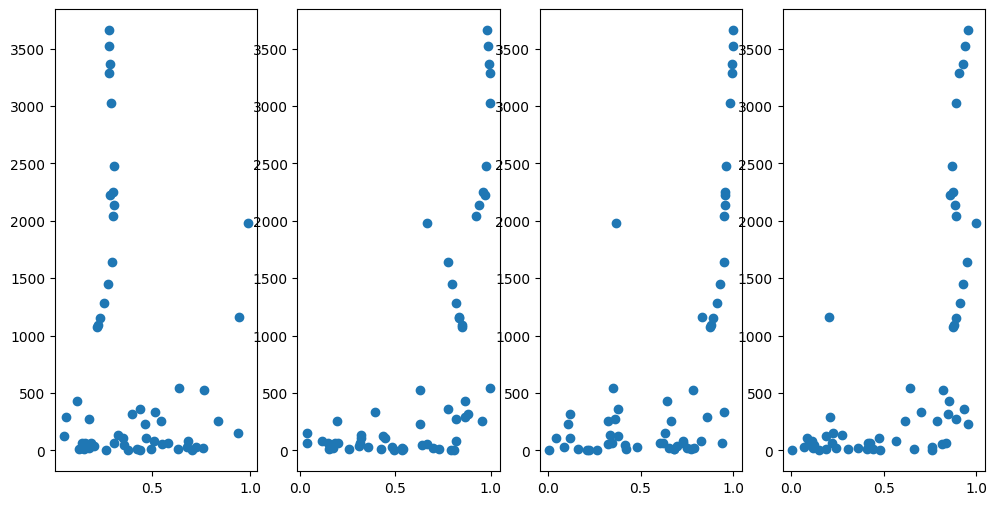

In [11]:
fig, ax = plt.subplots(1,4,figsize = (12,6))
ax[0].scatter(f5_inputs[:,0],f5_outputs)
ax[1].scatter(f5_inputs[:,1],f5_outputs)
ax[2].scatter(f5_inputs[:,2],f5_outputs)
ax[3].scatter(f5_inputs[:,3],f5_outputs)
plt.show()